In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch import nn

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [159]:
class MakeToydata(Dataset):
    def __init__(self, DATA_X, DATA_Y):
        self.data_x = DATA_X
        self.data_y = DATA_Y
        self.len = len(self.data_x)
        
    def __getitem__(self,index):
        return self.data_x[index], self.data_y[index]
    
    def __len__(self):
        return self.len

In [160]:
abs_xrange = 3
interval = 0.1
wide_sigma = 5
narrow_sigma = 3

data_x = np.arange(-abs_xrange, abs_xrange, interval)

data_y_neg = [np.power(x_, 3) + np.random.normal(0, wide_sigma) for x_ in data_x if x_ < 0]
data_y_pos = [np.power(x_, 3) + np.random.normal(0, narrow_sigma) for x_ in data_x if x_ >= 0]
data_y = np.array(data_y_neg + data_y_pos)

data_y_gt = [np.power(x_, 3) for x_ in data_x]

# split_ratio = 0.8
# train_num = int(len(data_x) * split_ratio)
# test_num = len(data_x) - train_num

# train_x, train_y = data_x[:train_num], data_y[:train_num]
# test_x, test_y = data_x[train_num:], data_y[train_num:]

dataset = MakeToydata(data_x, data_y)
data_loader = DataLoader(dataset = dataset, batch_size = 60, shuffle = True)

In [157]:
len(data_x)

60

## Single MSE

In [126]:
class SingleNet(nn.Module):
    def __init__(self):
        super(SingleNet, self).__init__()
        self.input_dim  = 1
        self.layer_dim  = 100
        self.output_dim = 1

        self.layer1 = nn.Sequential(
            nn.Linear(self.input_dim, self.layer_dim),
            nn.ReLU(),
        )

        self.layer2 = nn.Sequential(
            nn.Linear(self.layer_dim, self.output_dim),
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return x


singlenet = SingleNet()
mse_loss = nn.MSELoss()
optimizer = optim.Adam(singlenet.parameters(), lr = 0.1)


In [127]:
# Hyper-params
epochs = 100

losses = []
for epoch in range(epochs):
    batch_loss = 0

    for i, (x, y) in enumerate(data_loader):

        inputs = Variable(torch.unsqueeze(x, 1))
        labels = Variable(torch.unsqueeze(y, 1))

        optimizer.zero_grad()

        outputs = singlenet(inputs)

        loss = mse_loss(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_loss += loss.item()

    if epoch % 10 == 0:
        print(f"loss: {batch_loss/len(data_loader)}")
    losses.append(batch_loss/len(data_loader))

loss: 51.95065685112107
loss: 27.537856663474425
loss: 20.375502980904034
loss: 19.565370738312293
loss: 20.346405654897293
loss: 20.746209411819777
loss: 24.688097909783632
loss: 21.12470998329421
loss: 21.101540264238913
loss: 19.32472002474048


In [128]:
singlenet.eval()

x_for_plot = np.linspace(-5, 5, 400)
y_for_plot = [np.power(x_, 3) for x_ in x_for_plot]
pred = [singlenet(torch.tensor([x])) for x in x_for_plot]
pred = torch.tensor(pred).detach().numpy()


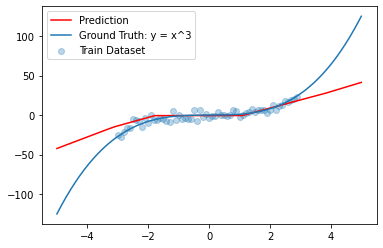

In [129]:
plt.plot(x_for_plot, pred, color = 'r', label = 'Prediction')
plt.plot(x_for_plot, y_for_plot, label = 'Ground Truth: y = x^3')
plt.scatter(data_x, data_y, alpha = 0.3, label = 'Train Dataset')
plt.legend(loc = 'best')

## Ensemble(MSE)

In [130]:
def load_ensemble(N):
    all_nets = []
    for i in range(N):
        weaknet = SingleNet()
        optimizer = optim.Adam(weaknet.parameters(), lr = 0.1)
        all_nets.append([weaknet, optimizer])
    return all_nets


def train_ensemble(net, optimizer, dataset, epochs):
    
    epochs = epochs
    single_net = net
    optimizer = optimizer

    losses = []
    for epoch in range(epochs):
        batch_loss = 0

        for i, (x, y) in enumerate(dataset):

            inputs = Variable(torch.unsqueeze(x, 1))
            labels = Variable(torch.unsqueeze(y, 1))

            optimizer.zero_grad()

            outputs = single_net(inputs)

            loss = mse_loss(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_loss += loss.item()

        losses.append(batch_loss/len(data_loader))

    return single_net

In [131]:
ensemble_nets = load_ensemble(5)
trained_nets = []
for a_net in tqdm(ensemble_nets):
    net_ = a_net[0]
    opt_ = a_net[1]

    trained_net = train_ensemble(net_, opt_, data_loader, epochs = 100)
    trained_nets.append(trained_net)

In [132]:
singlenet.eval()

predictions = []
for net in trained_nets:
    net.eval()
    
    x_for_plot = np.linspace(-5, 5, 400)
    pred = [net(torch.tensor([x])) for x in x_for_plot]
    pred = torch.tensor(pred).detach().numpy()
    predictions.append(pred)

In [133]:
ensem_mean = np.mean(predictions, axis = 0)
ensem_std = np.std(predictions, axis = 0)*3

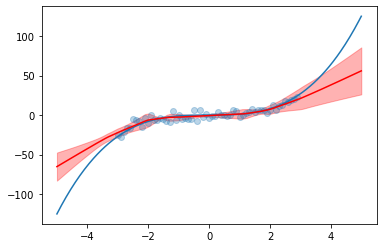

In [135]:
x_for_plot = np.linspace(-5, 5, 400)
y_for_plot = [np.power(x_, 3) for x_ in x_for_plot]

plt.plot(x_for_plot, y_for_plot)
plt.plot(x_for_plot, ensem_mean, color = 'r')
plt.fill_between(x_for_plot, ensem_mean+ensem_std, ensem_mean-ensem_std, color = 'r',  alpha=0.3)

plt.scatter(data_x, data_y, alpha = 0.3)

## Single NLL

In [288]:
class SingleNet(nn.Module):
    def __init__(self):
        super(SingleNet, self).__init__()
        self.input_dim  = 1
        self.layer_dim  = 100
        self.output_dim = 2

        self.layer1 = nn.Sequential(
            nn.Linear(self.input_dim, self.layer_dim),
            nn.ReLU(),
        )

        self.layer2 = nn.Sequential(
            nn.Linear(self.layer_dim, self.output_dim),
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        
        x = x.reshape(-1, 2)
        mu, var = torch.split(x, self.output_dim-1, dim=1)
        var = F.softplus(var) + 1e-6
        return mu, var


def sigma_softplus(x):
    softplus = torch.log(1+torch.exp(x))
    softplus = torch.where(softplus==float('inf'), x, softplus)
    return softplus

def nll_loss(mu, sigma, labels):
    var = sigma_softplus(sigma) + 1e-6
    loss = torch.div(torch.pow(torch.sub(labels, mu), 2), var)
    loss += torch.div(torch.log(var), 2)
    return torch.sum(loss)

# def nll_loss(mu, sigma, labels):
#     return (torch.log(sigma) + (labels-mu)**2/(2*sigma)).sum()

singlenet = SingleNet()
optimizer = optim.Adam(singlenet.parameters(), lr = 0.1)

# Hyper-params
epochs = 2000

losses = []
for epoch in range(epochs):
    batch_loss = 0

    for i, (x, y) in enumerate(data_loader):

        inputs = Variable(torch.unsqueeze(x, 1))
        labels = Variable(torch.unsqueeze(y, 1))

        optimizer.zero_grad()

        mu, sigma = singlenet(inputs)
        
        loss = nll_loss(mu, sigma, labels)
        loss.backward()
        optimizer.step()

        batch_loss += loss.item()

    if epoch % 100 == 0:
        print(f"loss: {batch_loss/len(data_loader)}")

    losses.append(batch_loss/len(data_loader))

loss: 6868.17919921875
loss: 132.9605255126953
loss: 127.4244155883789
loss: 124.30278015136719
loss: 123.17098999023438
loss: 122.31885528564453
loss: 122.01889038085938
loss: 121.84306335449219
loss: 121.70848846435547
loss: 121.61441040039062
loss: 121.41727447509766
loss: 121.55582427978516
loss: 121.25511169433594
loss: 121.14393615722656
loss: 121.00342559814453
loss: 122.11678314208984
loss: 120.74457550048828
loss: 121.73214721679688
loss: 120.23139190673828
loss: 121.3687973022461


In [289]:
singlenet.eval()

x_for_plot = np.linspace(-4, 4, 400)
y_for_plot = [np.power(x_, 3) for x_ in x_for_plot]

pred_mu = list(map(lambda r: r.detach().numpy(), [singlenet(torch.tensor([x]))[0] for x in x_for_plot]))
pred_sigma = list(map(lambda r: np.sqrt(r.detach().numpy())*3, [singlenet(torch.tensor([x]))[1] for x in x_for_plot]))

pred_mu = np.array(pred_mu)
pred_sigma = np.array(pred_sigma)

In [290]:
pred_mu = pred_mu.reshape(-1)
pred_sigma = pred_sigma.reshape(-1)

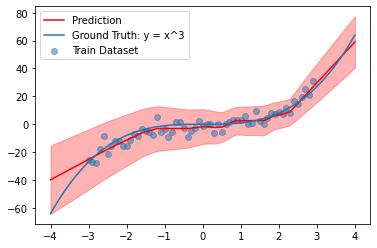

In [291]:
plt.plot(x_for_plot, pred_mu.reshape(-1), color = 'r', label = 'Prediction')
plt.plot(x_for_plot, y_for_plot, label = 'Ground Truth: y = x^3')
plt.fill_between(x_for_plot, pred_mu+pred_sigma, pred_mu-pred_sigma, color = 'r',  alpha=0.3)
plt.scatter(data_x, data_y, alpha = 0.5, label = 'Train Dataset')
plt.legend(loc = 'best')

## Ensemble + NLL

In [279]:
class SingleNet(nn.Module):
    def __init__(self):
        super(SingleNet, self).__init__()
        self.input_dim  = 1
        self.layer_dim  = 100
        self.output_dim = 2

        self.layer1 = nn.Sequential(
            nn.Linear(self.input_dim, self.layer_dim),
            nn.ReLU(),
        )

        self.layer2 = nn.Sequential(
            nn.Linear(self.layer_dim, self.output_dim),
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        
        x = x.reshape(-1, 2)
        mu, var = torch.split(x, self.output_dim-1, dim=1)
        var = F.softplus(var) + 1e-6
        return mu, var


def sigma_softplus(x):
    softplus = torch.log(1+torch.exp(x))
    softplus = torch.where(softplus==float('inf'), x, softplus)
    return softplus

def nll_loss(mu, sigma, labels):
    var = sigma_softplus(sigma) + 1e-6
    loss = torch.div(torch.pow(torch.sub(labels, mu), 2), var)
    loss += torch.div(torch.log(var), 2)
    return torch.sum(loss)

#nll_loss = lambda mu, sigma, y: torch.log(sigma)/2 + ((y-mu)**2)/(2*sigma)

In [280]:
def load_ensemble(N):
    all_nets = []
    for i in range(N):
        weaknet = SingleNet()
        optimizer = optim.Adam(weaknet.parameters(), lr = 0.1)
        all_nets.append((weaknet, optimizer))
    return all_nets

def train_ensemble(net, optimizer, dataset, epochs):
    epochs = epochs
    single_net = net
    optimizer = optimizer

    losses = []

    for epoch in range(epochs):

        batch_loss = 0
        for i, (x, y) in enumerate(data_loader):

            inputs = torch.unsqueeze(x, 1)
            labels = torch.unsqueeze(y, 1)

            optimizer.zero_grad()

            outputs = singlenet(inputs)
            mu, sigma = singlenet(inputs)
            
            loss = nll_loss(mu, sigma, labels)
            loss.backward()
            optimizer.step()

            batch_loss += loss.item()

        losses.append(batch_loss/len(data_loader))

    return single_net

In [281]:
ensemble_nets = load_ensemble(5)
trained_nets = []
for a_net in tqdm(ensemble_nets, desc = "Training single models"):
    net_ = a_net[0]
    opt_ = a_net[1]

    trained_net = train_ensemble(net_, opt_, data_loader, epochs = 2000)
    trained_nets.append(trained_net)

Training single models: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


In [285]:
predictions_mu = []
predictions_sigma = []
for net in trained_nets:
    net.eval()
    
    x_for_plot = np.linspace(-4, 4, 400)
    y_for_plot = [np.power(x_, 3) for x_ in x_for_plot]

    pred_mu = list(map(lambda r: r.detach().numpy(), [singlenet(torch.tensor([x]))[0] for x in x_for_plot]))
    pred_sigma = list(map(lambda r: np.sqrt(r.detach().numpy())*3, [singlenet(torch.tensor([x]))[1] for x in x_for_plot]))
    
    pred_mu = np.array(pred_mu).reshape(-1)
    pred_sigma = np.array(pred_sigma).reshape(-1)
    
    predictions_mu.append(pred_mu)
    predictions_sigma.append(pred_sigma)

In [286]:
# MU
ensem_mus = np.vstack(predictions_mu)
ensem_nll_mean = np.mean(ensem_mus, axis = 0)

# Sigma
ensem_sigma = np.vstack(predictions_sigma)

# Final values
var_fin = np.mean(np.power(ensem_mus, 2) + ensem_sigma, axis = 0) - np.power(ensem_nll_mean, 2)
sig_fin = np.sqrt(var_fin)*3

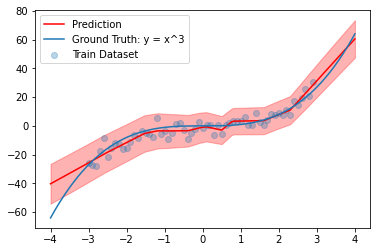

In [287]:
plt.plot(x_for_plot, ensem_nll_mean, color = 'r', label = 'Prediction')
plt.plot(x_for_plot, y_for_plot, label = 'Ground Truth: y = x^3')
plt.fill_between(x_for_plot, ensem_nll_mean+sig_fin, ensem_nll_mean-sig_fin, color = 'r',  alpha=0.3)
plt.scatter(data_x, data_y, alpha = 0.3, label = 'Train Dataset')
plt.legend(loc = 'best')